# *Twitter EDA & Sentiment Analysis: Logistic Regression, LSTM, and BERT Models*
This project analyzes a dataset of tweets to classify sentiments into three categories: positive, negative, and neutral.
Three models—Logistic Regression, LSTM, and BERT—are implemented and compared in terms of accuracy, F1 score,
and computational efficiency. The objective is to evaluate the strengths and limitations of each approach
and provide recommendations for real-world applications.


1. Installing and importing necessary libraries

In [2]:
!python -m pip install nltk wordcloud textblob emoji plotly seaborn matplotlib


# Import the libraries we will use
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import emoji
import html
import nltk
import torch
from nltk.corpus import stopwords
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
import plotly.express as px
from collections import Counter
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import confusion_matrix
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from transformers import AdamW
from tqdm.notebook import tqdm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, Input, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Adjust display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)
pd.set_option('display.float_format', lambda x: '%.2f' % x)


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\elifs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\elifs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\elifs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\elifs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# DATA OVERVIEW

Overview of the data 

In [7]:
# Load the dataset after uploading
df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding='latin1')
df.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']


In [8]:
# Brief overview of the dataset
df.head()


target         ids                          date      flag           user                                               text
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF    my whole body feels itchy and like its on fire 
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli  @nationwideclass no, it's not behaving at all....
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf                      @Kwesidei not the whole crew

In [9]:
# Check for missing values
df.isnull().sum()

target    0
ids       0
date      0
flag      0
user      0
text      0
dtype: int64

In [10]:
# Describe the dataset
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

df.info()

Number of rows: 1599999
Number of columns: 6
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1599999 non-null  int64 
 1   ids     1599999 non-null  int64 
 2   date    1599999 non-null  object
 3   flag    1599999 non-null  object
 4   user    1599999 non-null  object
 5   text    1599999 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


# Data Preprocessing

The preprocessing step ensures the raw data is cleaned, transformed, and prepared for input into the model. It involves handling missing values, normalizing sentiment labels to a consistent range (negative, neutral, positive), converting text data into sequences of integers using tokenization, and padding these sequences to ensure they are of uniform length. Additionally, labels are encoded as one-hot vectors for multi-class classification. These transformations standardize the data, making it suitable for training a deep learning model.

In [11]:
# Step 1: Convert all text to lowercase
df['cleaned_text'] = df['text'].str.lower()

In [12]:
# Step 2: Handle emojis - convert them to text descriptions
def emoji_to_text(text):
    return emoji.demojize(text)  # Convert emoji to textual descriptions

df['text'] = df['text'].apply(emoji_to_text)

In [13]:
# Step 3: Remove mentions

def remove_mentions(text):
    # Match any mention starting with "@" and followed by word characters
    text = re.sub(r"@\w+", "", text)
    return text
df['cleaned_text'] = df['cleaned_text'].apply(remove_mentions)


In [14]:
# Step 4: Remove HTML entities
def clean_html_entities(text):
    # Decode all HTML entities in the text
    text = html.unescape(text)  # Convert &amp; to &, etc.
    # Remove any remaining HTML artifacts if needed (after unescaping)
    text = re.sub(r'&[a-zA-Z0-9#]+;', '', text)  # Remove entities like &lt;, &#39;, etc.
    # Use BeautifulSoup to remove any lingering HTML tags or entities
    text = BeautifulSoup(text, "html.parser").get_text()
    return text

df['cleaned_text'] = df['cleaned_text'].apply(clean_html_entities)

In [15]:
# Step 5: Remove punctuation and numerical characters
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [16]:
# Step 6: Expand contractions and slang
contractions_dict = {
    r"\bI'm\b": "I am",
    r"\bim\b": "i am",
    r"\bcan't\b": "cannot",
    r"\bcant\b": "cannot",
    r"\bwon't\b": "will not",
    r"\baren't\b": "are not",
    r"\bisn't\b": "is not",
    r"\bwasn't\b": "was not",
    r"\bweren't\b": "were not",
    r"\bdoesn't\b": "does not",
    r"\bdon't\b": "do not",
    r"\bdont\b": "do not",
    r"\bdidn't\b": "did not",
    r"\bhadn't\b": "had not",
    r"\bhaven't\b": "have not",
    r"\bhasn't\b": "has not",
    r"\bshouldn't\b": "should not",
    r"\bcouldn't\b": "could not",
    r"\bwouldn't\b": "would not",
    r"\bmustn't\b": "must not",
    r"\bn't\b": " not",
    r"\bi'll\b": "i will",
    r"\byou're\b": "you are",
    r"\bit's\b": "it is",
    r"\bthey're\b": "they are",
    r"\bhe's\b": "he is",
    r"\bshe's\b": "she is",
    r"\bi've\b": "i have",
    r"\bwe've\b": "we have",
    r"\byou've\b": "you have",
    r"\bthey've\b": "they have",
    r"\bu\b": "you",
    r"\bur\b": "your",
    r"\bthx\b": "thanks",
    r"\bpls\b": "please",
    r"\bwanna\b": "want to",
    r"\bgonna\b": "going to",
    r"\bgotta\b": "got to",
    r"\bya\b": "you",
    r"\blol\b": "laughing out loud",
    r"\bhaha\b": "laugh",
    r"\bomg\b": "oh my god",
    r"\br\b": "are",
    r"\bd\b": "the",
    r"\bamp\b": "",
}

def expand_contractions_and_slang(text):
    for contraction, expanded in contractions_dict.items():
        text = re.sub(contraction, expanded, text, flags=re.IGNORECASE)
    return text

df['cleaned_text'] = df['cleaned_text'].apply(expand_contractions_and_slang)

In [17]:
# Step 7: Remove stopwords
stop_words = set(stopwords.words('english'))
df['cleaned_text'] = df['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))


In [18]:
# Step 8: Tokenize each text entry
df['tokens'] = df['text'].apply(lambda x: nltk.word_tokenize(x))


In [19]:
# Step 9: Tokenize each text entry
lemmatizer = WordNetLemmatizer()
df['tokens'] = df['cleaned_text'].apply(lambda x: nltk.word_tokenize(x))
df['tokens'] = df['tokens'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['cleaned_text'] = df['tokens'].apply(lambda x: ' '.join(x))


In [39]:
from textblob import TextBlob

# Define a function to get sentiment label from polarity
def get_sentiment_label(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0:
        return 4  # Positive sentiment
    elif polarity < 0:
        return 0  # Negative sentiment
    else:
        return 2  # Neutral sentiment

# Apply the function to create a new 'sentiment' column
df['sentiment'] = df['cleaned_text'].apply(get_sentiment_label)

# Check the distribution of the sentiment labels
print(df['sentiment'].value_counts())


sentiment
4    674693
2    595819
0    329487
Name: count, dtype: int64


In [40]:
# Original sentiment column values (e.g., [0, 2, 4] for Negative, Neutral, Positive)
# Create a mapping for valid range
sentiment_mapping = {0: 0, 2: 1, 4: 2}  # Map Negative (0), Neutral (2), Positive (4) to [0, 1, 2]

# Create a new column for adjusted sentiment labels
df['adjusted_sentiment'] = df['sentiment'].map(sentiment_mapping)

# Verify the new column
print(df[['sentiment', 'adjusted_sentiment']].head())


   sentiment  adjusted_sentiment
0          2                   1
1          4                   2
2          4                   2
3          0                   0
4          4                   2


In [20]:
# Display few rows to review preprocessing results
df[['text', 'cleaned_text']].head(10)

text                                       cleaned_text
0  is upset that he can't update his Facebook by ...  upset can not update facebook texting might cr...
1  @Kenichan I dived many times for the ball. Man...    dived many time ball managed save rest go bound
2    my whole body feels itchy and like its on fire                     whole body feel itchy like fire
3  @nationwideclass no, it's not behaving at all....                           behaving mad can not see
4                      @Kwesidei not the whole crew                                          whole crew
5                                        Need a hug                                            need hug
6  @LOLTrish hey  long time no see! Yes.. Rains a...  hey long time see yes rain bit bit laughing lo...
7               @Tatiana_K nope they didn't have it                                          nope didnt
8                          @twittera que me muera ?                                           que muera
9        spring break in plain city... it's snowing                     spring break plain city snowing

# Exploratory Data Analysis (EDA)

The exploratory data analysis (EDA) step provides insights into the dataset, helping to understand its structure and distribution. By visualizing the most frequent words using bar charts and word clouds, we identify key terms associated with each sentiment class. Additionally, analyzing the sentiment distribution highlights potential imbalances that might affect model performance. This step lays the foundation for informed preprocessing and model-building decisions.

In [21]:
# Calculate term frequencies

all_words = ' '.join(df['cleaned_text']).split()
word_freq = Counter(all_words)

# Convert to DataFrame for easier handling
word_freq_df = pd.DataFrame(word_freq.items(), columns=['word', 'frequency']).sort_values(by='frequency', ascending=False)


print(word_freq_df.head(30))

# Save as CSV
word_freq_df.to_csv('word_frequency.csv', index=False)


         word  frequency
104       day     104354
187      good      89781
121     going      87659
105       get      86065
26       like      79173
20         go      77609
77        got      69855
96       love      67274
165      work      66611
10      today      66198
1         can      65764
2         not      65666
151      want      64810
15       time      64019
40       loud      56377
39   laughing      56359
179      back      56210
108       one      56080
197      know      53294
98         oh      50064
71     really      49589
30        see      46120
319      well      44642
170     night      43657
195     think      43528
216     still      42868
150       new      42151
42     thanks      42069
32       need      40501
956      home      39463


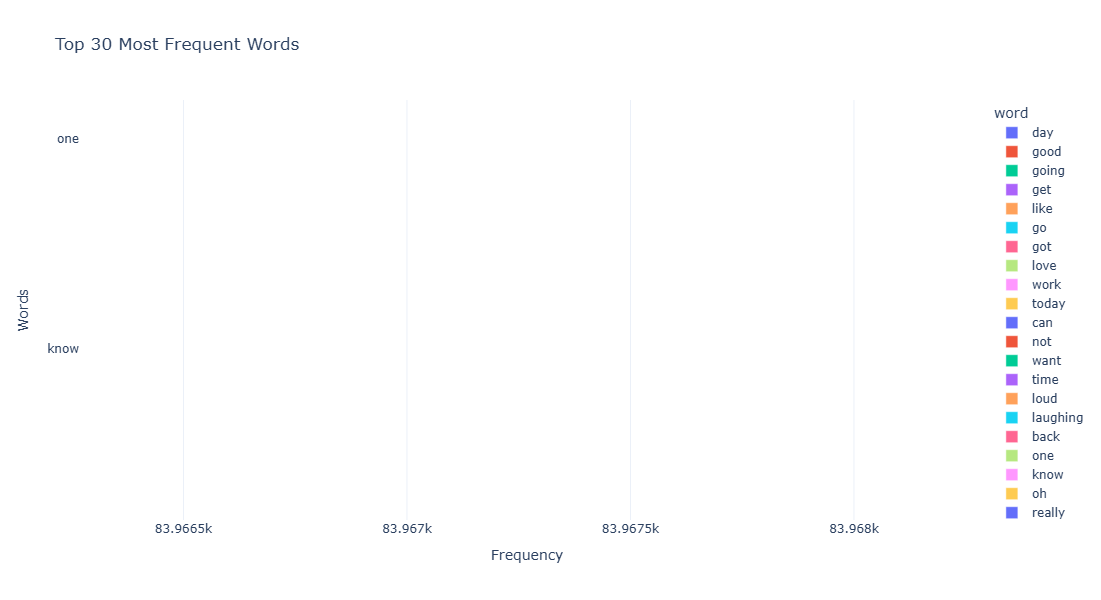

In [22]:
# Create a bar chart
fig = px.bar(
    word_freq_df.head(30),  
    x="frequency",  
    y="word",
    title='Top 30 Most Frequent Words',
    orientation='h',
    width=800,
    height=600,
    color='word', 
)


fig.update_layout(
    xaxis_title="Frequency",
    yaxis_title="Words",
    template="plotly_white"
)


fig.show()


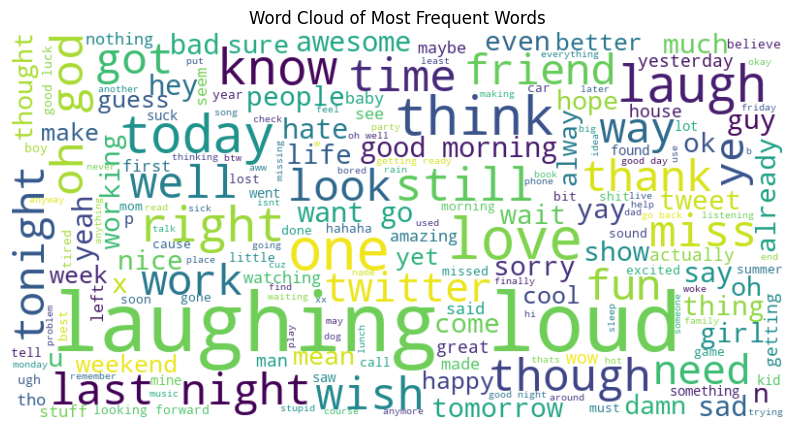

In [23]:
# Generate a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['cleaned_text']))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Words')
plt.show()


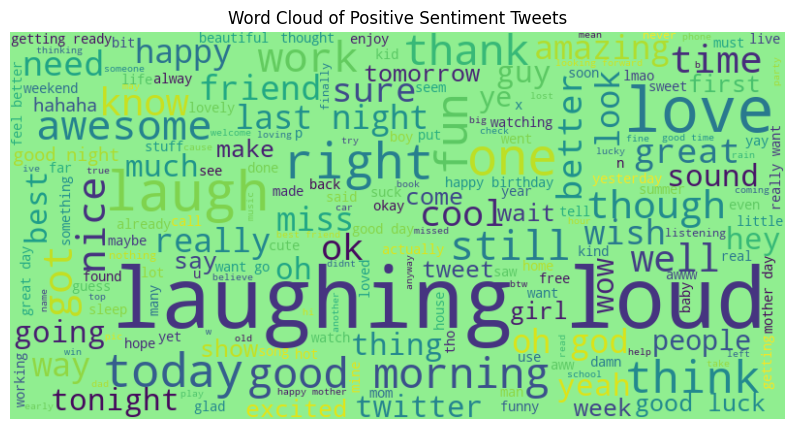

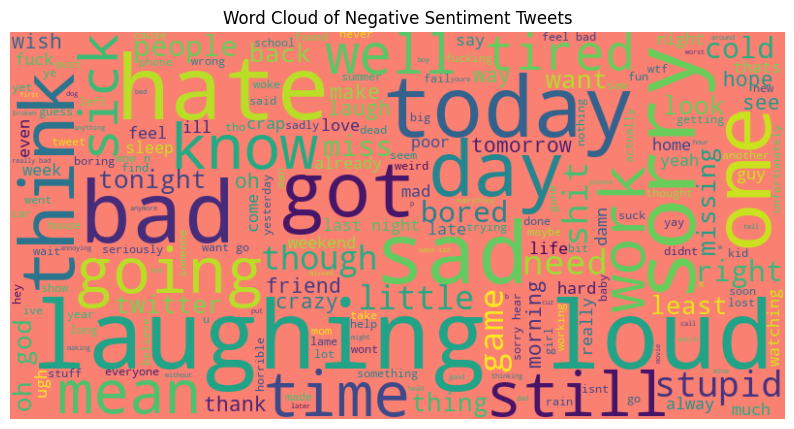

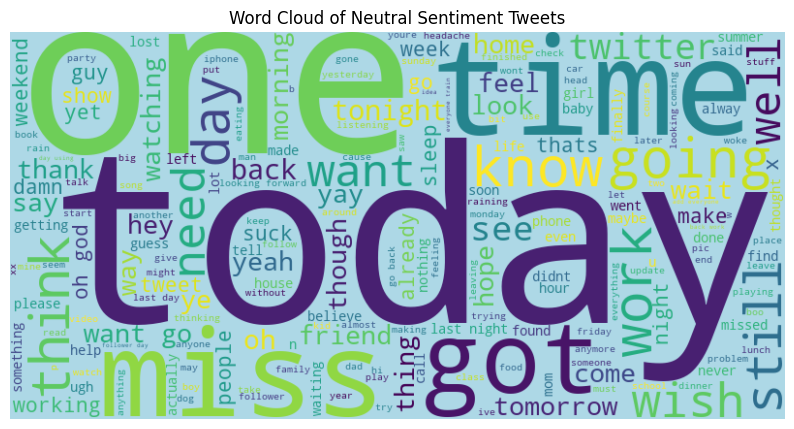

In [26]:
# Positive sentiment tweets
positive_text = ' '.join(df[df['sentiment'] == 4]['cleaned_text'])
if not positive_text.strip():
    print("No positive sentiment tweets found.")
else:
    # Generate word cloud for positive sentiment tweets
    plt.figure(figsize=(10, 6))
    positive_wc = WordCloud(width=800, height=400, background_color='lightgreen').generate(positive_text)
    plt.imshow(positive_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Positive Sentiment Tweets')
    plt.show()

# Negative sentiment tweets
negative_text = ' '.join(df[df['sentiment'] == 0]['cleaned_text'])
if not negative_text.strip():
    print("No negative sentiment tweets found.")
else:
    # Generate word cloud for negative sentiment tweets
    plt.figure(figsize=(10, 6))
    negative_wc = WordCloud(width=800, height=400, background_color='salmon').generate(negative_text)
    plt.imshow(negative_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Negative Sentiment Tweets')
    plt.show()

# Neutral sentiment tweets
neutral_text = ' '.join(df[df['sentiment'] == 2]['cleaned_text'])
if not neutral_text.strip():
    print("No neutral sentiment tweets found.")
else:
    # Generate word cloud for neutral sentiment tweets
    plt.figure(figsize=(10, 6))
    neutral_wc = WordCloud(width=800, height=400, background_color='lightblue').generate(neutral_text)
    plt.imshow(neutral_wc, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Neutral Sentiment Tweets')
    plt.show()


sentiment
0    329487
2    595819
4    674693
Name: count, dtype: int64


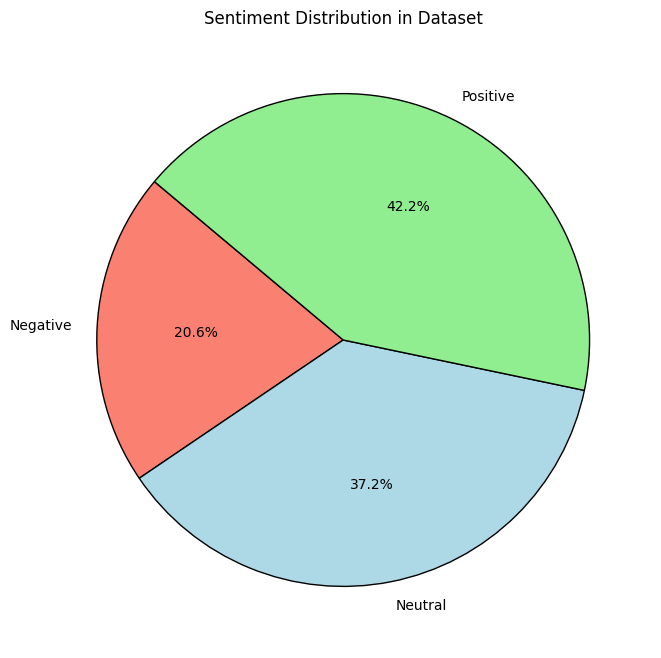

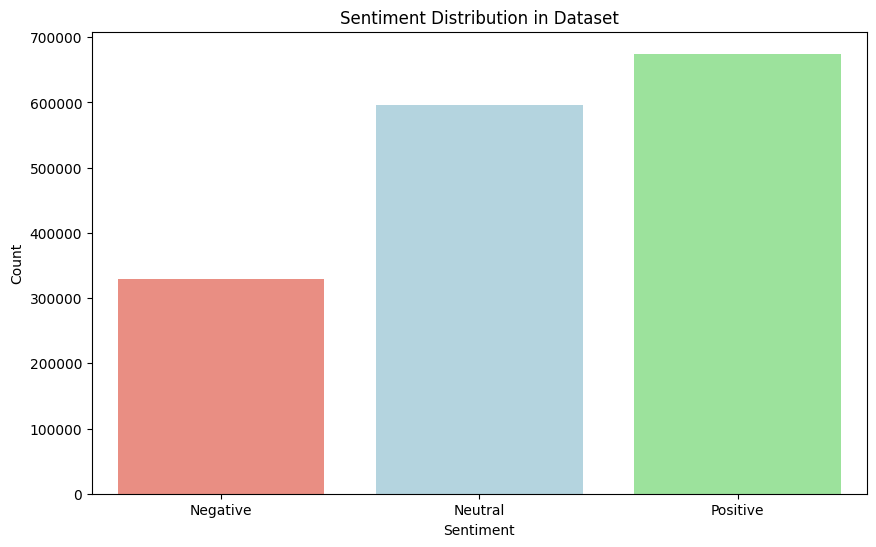

In [39]:
sentiment_counts = df['sentiment'].value_counts().sort_index()
print(sentiment_counts)

# Pie chart for sentiment distribution
plt.figure(figsize=(8, 8))
plt.pie(
    sentiment_counts,
    labels=['Negative', 'Neutral', 'Positive'],
    autopct='%1.1f%%',
    startangle=140,
    colors=['salmon', 'lightblue', 'lightgreen'],
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Sentiment Distribution in Dataset')
plt.show()

# Bar chart for sentiment distribution
plt.figure(figsize=(10, 6))

# Make sure the index is used to specify sentiment categories
sns.barplot(
    x=sentiment_counts.index.astype(str),  
    y=sentiment_counts.values,
    palette=['salmon', 'lightblue', 'lightgreen']
)

plt.xticks(ticks=[0, 1, 2], labels=['Negative', 'Neutral', 'Positive'])  
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in Dataset')
plt.show()


# Logistic Regression

In [27]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), stop_words='english')

# Apply TF-IDF transformation to the cleaned text
X = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Set target variable
y = df['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Initialize and train the logistic regression model
log_model = LogisticRegression(max_iter=200)
log_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
print(f'Logistic Regression Accuracy: {log_accuracy:.2f}')
print("Classification Report for Logistic Regression:")
print(classification_report(y_test, y_pred_log, target_names=['Negative', 'Neutral', 'Positive']))


Logistic Regression Accuracy: 0.95
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

    Negative       0.96      0.93      0.94     65690
     Neutral       0.93      0.98      0.96    119185
    Positive       0.98      0.94      0.96    135125

    accuracy                           0.95    320000
   macro avg       0.95      0.95      0.95    320000
weighted avg       0.95      0.95      0.95    320000



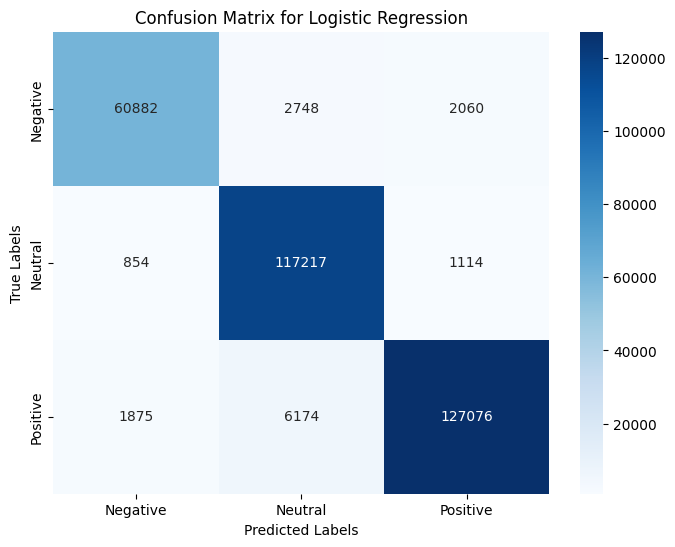

In [29]:

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_log)

# Visualize confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues', 
    xticklabels=['Negative', 'Neutral', 'Positive'], 
    yticklabels=['Negative', 'Neutral', 'Positive']
)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Logistic Regression')
plt.show()

In [30]:
# Example sentences
example_sentences = [
    "I love the new design of this app!",
    "This product is terrible and I hate it.",
    "It is wednesday today.",
    "I am extremely satisfied with the service.",
    "What a disappointing experience."
]

# Transform the examples using the trained TF-IDF vectorizer
example_features = tfidf_vectorizer.transform(example_sentences)

# Make predictions
predicted_sentiments = log_model.predict(example_features)

# Adjusted sentiment mapping based on dataset
sentiment_mapping = {0: 'Negative', 2: 'Neutral', 4: 'Positive'}
predicted_labels = [sentiment_mapping[sentiment] for sentiment in predicted_sentiments]

# Print predictions
for sentence, label in zip(example_sentences, predicted_labels):
    print(f"Input: {sentence}")
    print(f"Predicted Sentiment: {label}\n")


Input: I love the new design of this app!
Predicted Sentiment: Positive

Input: This product is terrible and I hate it.
Predicted Sentiment: Negative

Input: It is wednesday today.
Predicted Sentiment: Neutral

Input: I am extremely satisfied with the service.
Predicted Sentiment: Negative

Input: What a disappointing experience.
Predicted Sentiment: Negative



# LSTM 

In [48]:
# Step 1: Load and preprocess data
# Replace NaN with empty string and convert text to string type
df['cleaned_text'] = df['cleaned_text'].fillna("").astype(str)

# Tokenize and pad sequences
max_len = 100  # Max length of sequences
vocab_size = 10000  # Number of most frequent words to consider
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['cleaned_text'])
sequences = tokenizer.texts_to_sequences(df['cleaned_text'])
padded_sequences = pad_sequences(sequences, maxlen=max_len)

# Convert sentiment labels to one-hot encoding
labels = df['adjusted_sentiment']
labels_one_hot = to_categorical(labels, num_classes=3)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, labels_one_hot, test_size=0.2, random_state=42
)



In [44]:
# Step 2: Building the LSTM model
def build_lstm_model():
    inputs = Input(shape=(max_len,))
    x = Embedding(input_dim=vocab_size, output_dim=50, input_length=max_len)(inputs)
    x = Bidirectional(LSTM(64))(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(3, activation='softmax')(x)  # Softmax for multi-class classification
    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_lstm_model()

# Step 3: Handling class imbalance
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(df['adjusted_sentiment']),
    y=df['adjusted_sentiment']
)
class_weights = dict(enumerate(class_weights))

# Step 4: Train the model
history = model.fit(
    X_train, y_train,
    batch_size=64,
    epochs=5,
    validation_split=0.1,
    callbacks=[early_stopping],
    class_weight=class_weights
)


Epoch 1/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 686s 38ms/step - accuracy: 0.9515 - loss: 0.1439 - val_accuracy: 0.9906 - val_loss: 0.0408
Epoch 2/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 808s 45ms/step - accuracy: 0.9908 - loss: 0.0419 - val_accuracy: 0.9925 - val_loss: 0.0352
Epoch 3/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 1063s 59ms/step - accuracy: 0.9933 - loss: 0.0336 - val_accuracy: 0.9933 - val_loss: 0.0341
Epoch 4/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 1145s 64ms/step - accuracy: 0.9942 - loss: 0.0297 - val_accuracy: 0.9926 - val_loss: 0.0371
Epoch 5/5
18000/18000 ━━━━━━━━━━━━━━━━━━━━ 1140s 63ms/step - accuracy: 0.9950 - loss: 0.0256 - val_accuracy: 0.9934 - val_loss: 0.0351


In [45]:
# Step 5: Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

# Step 6: Generate classification report
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)  # Convert probabilities to class labels
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels back to class labels

print(classification_report(y_true, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 218s 22ms/step - accuracy: 0.9934 - loss: 0.0336
Test Accuracy: 0.99
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 130s 13ms/step
              precision    recall  f1-score   support

    Negative       0.99      0.99      0.99     65690
     Neutral       0.99      1.00      1.00    119185
    Positive       0.99      0.99      0.99    135125

    accuracy                           0.99    320000
   macro avg       0.99      0.99      0.99    320000
weighted avg       0.99      0.99      0.99    320000



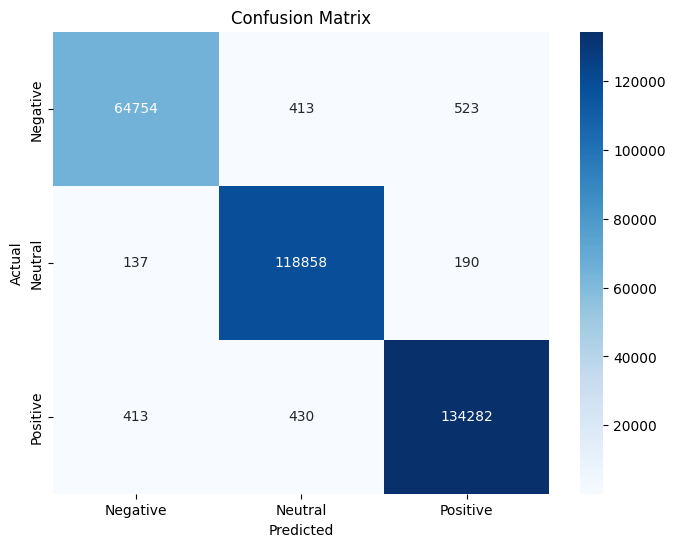

In [47]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'], yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [51]:
# Define max_len based on the training setup
max_len = 100  # Ensure this matches the value used during training

# Example sentences for sentiment prediction
example_sentences = [
    "I love the new design of this app!",
    "This product is terrible and I hate it.",
    "It is wednesday today.",
    "I am extremely satisfied with the service.",
    "What a disappointing experience."
]

# Preprocess the sentences: tokenize and pad
example_sequences = tokenizer.texts_to_sequences(example_sentences)  # Tokenize the sentences
example_padded = pad_sequences(example_sequences, maxlen=max_len)  # Pad to the same length as training data

# Predict sentiment probabilities for the example sentences
predictions = model.predict(example_padded)

# Map class indices to sentiment labels
sentiment_labels = {0: "Negative", 1: "Neutral", 2: "Positive"}

# Print predictions
for i, sentence in enumerate(example_sentences):
    predicted_class = np.argmax(predictions[i])  # Get the class with the highest probability
    confidence = predictions[i][predicted_class]  # Get confidence score
    print(f"Sentence: '{sentence}'")
    print(f"Predicted Sentiment: {sentiment_labels[predicted_class]} (Confidence: {confidence:.2f})")
    print()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Sentence: 'I love the new design of this app!'
Predicted Sentiment: Positive (Confidence: 1.00)

Sentence: 'This product is terrible and I hate it.'
Predicted Sentiment: Negative (Confidence: 1.00)

Sentence: 'It is wednesday today.'
Predicted Sentiment: Neutral (Confidence: 1.00)

Sentence: 'I am extremely satisfied with the service.'
Predicted Sentiment: Positive (Confidence: 1.00)

Sentence: 'What a disappointing experience.'
Predicted Sentiment: Negative (Confidence: 1.00)



# BERT 

BERT model requires a significant amount of computational power. To address this, I created a preprocessed_data.csv file containing the preprocessed data. This was necessary because the BERT model often caused the kernel to crash due to insufficient CPU resources. For the same reason, only 1% of the dataset was used for model deployment.

In [40]:
import pandas as pd

# Load the cleaned data
df = pd.read_csv('preprocessed_datayenivers.csv')

# Preview the first few rows
print(df.head())

   target         ids                          date      flag           user                                               text                                       cleaned_text  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton  is upset that he can't update his Facebook by ...  upset cant update facebook texting might cry r...   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus  @Kenichan I dived many times for the ball. Man...    dived many time ball managed save rest go bound   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF    my whole body feels itchy and like its on fire                     whole body feel itchy like fire   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli  @nationwideclass no, it's not behaving at all....                              behaving mad cant see   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf              

In [41]:
# Map sentiment labels to 0, 1, 2 (Negative, Neutral, Positive)
sentiment_mapping = {0: 0, 2: 1, 4: 2}
df['adjusted_sentiment'] = df['sentiment'].map(sentiment_mapping)

# Ensure no NaN values in the cleaned text
df['cleaned_text'] = df['cleaned_text'].fillna("").astype(str)

# Small sample of the data for quicker experimentation
df = df.sample(frac=0.01, random_state=42).reset_index(drop=True)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['cleaned_text'].tolist(),
    df['adjusted_sentiment'].tolist(),
    test_size=0.2,
    random_state=42
)

In [42]:
print(f"Training samples: {len(train_texts)}")
print(f"Validation samples: {len(val_texts)}")


Training samples: 12800
Validation samples: 3200


In [44]:
# Step 4: Tokenize the dataset using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize train and validation sets
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128, return_tensors="pt")

# Step 5: Create a custom dataset class
class SentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

train_dataset = SentimentDataset(train_encodings, train_labels)
val_dataset = SentimentDataset(val_encodings, val_labels)

In [45]:
# Step 6: Load the BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

# Step 7: Set up DataLoader
batch_size = 16
train_loader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
val_loader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=batch_size)

# Step 8: Set up Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=5e-5, eps=1e-8)

# Step 9: Train the BERT model

epochs = 4

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
        optimizer.zero_grad()

        inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)

        outputs = model(**inputs, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(train_loader)}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/4:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 1/4, Loss: 0.365600111214444


Epoch 2/4:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 2/4, Loss: 0.1600014113835641


Epoch 3/4:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 3/4, Loss: 0.11576420012395829


Epoch 4/4:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch 4/4, Loss: 0.07275173041009111


In [46]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score

def evaluate(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            # Move batch data to device
            inputs = {key: val.to(device) for key, val in batch.items() if key != 'labels'}
            labels = batch['labels'].to(device)

            # Get predictions
            outputs = model(**inputs)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)

            # Append results
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    report = classification_report(all_labels, all_preds, target_names=['Negative', 'Neutral', 'Positive'])
    cm = confusion_matrix(all_labels, all_preds)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("\nClassification Report:\n", report)
    print("\nConfusion Matrix:\n", cm)

    return accuracy, f1, cm

# Run the evaluation
evaluate(model, val_loader)

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.9566
F1 Score: 0.9563

Classification Report:
               precision    recall  f1-score   support

    Negative       0.96      0.89      0.92       679
     Neutral       0.95      0.98      0.96      1150
    Positive       0.96      0.97      0.97      1371

    accuracy                           0.96      3200
   macro avg       0.96      0.95      0.95      3200
weighted avg       0.96      0.96      0.96      3200


Confusion Matrix:
 [[ 605   35   39]
 [   8 1124   18]
 [  18   21 1332]]


(0.9565625,
 np.float64(0.956252774814146),
 array([[ 605,   35,   39],
        [   8, 1124,   18],
        [  18,   21, 1332]]))

Evaluating:   0%|          | 0/200 [00:00<?, ?it/s]

Accuracy: 0.9566
F1 Score: 0.9563

Classification Report:
               precision    recall  f1-score   support

    Negative       0.96      0.89      0.92       679
     Neutral       0.95      0.98      0.96      1150
    Positive       0.96      0.97      0.97      1371

    accuracy                           0.96      3200
   macro avg       0.96      0.95      0.95      3200
weighted avg       0.96      0.96      0.96      3200


Confusion Matrix:
 [[ 605   35   39]
 [   8 1124   18]
 [  18   21 1332]]


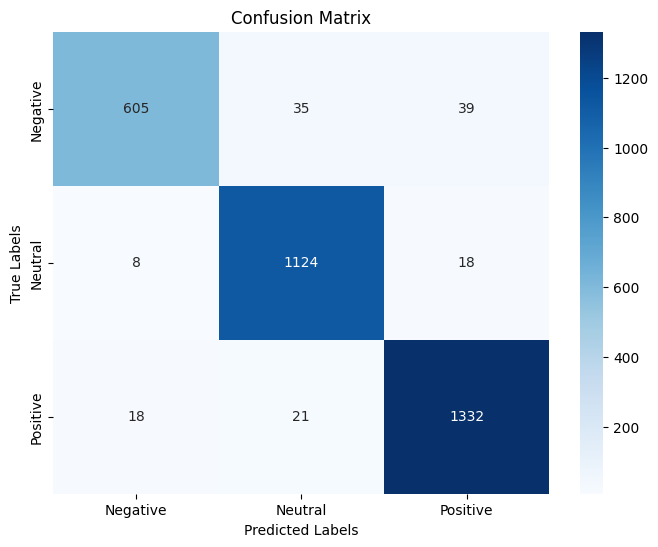

In [47]:
# Evaluate the model and capture the confusion matrix
accuracy, f1, cm = evaluate(model, val_loader)

# Plot the confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

labels = ['Negative', 'Neutral', 'Positive']
plot_confusion_matrix(cm, labels)

In [22]:
import torch
import time

def predict(sentence):
    # Tokenize the input text
    inputs = tokenizer(sentence, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Start timing for performance measurement
    start_time = time.time()
    
    # Get predictions
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.nn.functional.softmax(logits, dim=-1)
    
    # Get the label with the highest probability
    max_prob, predicted_label = torch.max(probabilities, dim=1)
    elapsed_time = time.time() - start_time
    
    # Map label index to sentiment
    label_map = {0: 'NEGATIVE', 1: 'NEUTRAL', 2: 'POSITIVE'}
    label = label_map[predicted_label.item()]
    
    return {
        'label': label,
        'score': max_prob.item(),
        'elapsed_time': elapsed_time
    }


In [24]:
# Example sentences
sentences = [
    "This is the best day of my life!",
    "What a terrible experience!",
    "I had a walk today.",
    "I'm feeling so happy and excited today!",
    "The weather is gloomy, but I feel indifferent about it.",
    "The food was delicious, and the service was excellent.",
    "I'm confused about what to do next.",
    "That was a waste of time and money.",
    "This is absolutely fantastic!",
    "Just booked two nights at this hotel."
    
]

# Generate predictions
for sentence in sentences:
    print(f"Input: {sentence}")
    print("Prediction:", predict(sentence))
    print()


Input: This is the best day of my life!
Prediction: {'label': 'POSITIVE', 'score': 0.9987333416938782, 'elapsed_time': 0.030836820602416992}

Input: What a terrible experience!
Prediction: {'label': 'NEGATIVE', 'score': 0.9955911636352539, 'elapsed_time': 0.03587150573730469}

Input: I had a walk today.
Prediction: {'label': 'NEUTRAL', 'score': 0.8625007271766663, 'elapsed_time': 0.03355693817138672}

Input: I'm feeling so happy and excited today!
Prediction: {'label': 'POSITIVE', 'score': 0.9986478686332703, 'elapsed_time': 0.01348567008972168}

Input: The weather is gloomy, but I feel indifferent about it.
Prediction: {'label': 'NEGATIVE', 'score': 0.6925603151321411, 'elapsed_time': 0.031301021575927734}

Input: The food was delicious, and the service was excellent.
Prediction: {'label': 'POSITIVE', 'score': 0.9987467527389526, 'elapsed_time': 0.03125166893005371}

Input: I'm confused about what to do next.
Prediction: {'label': 'NEGATIVE', 'score': 0.9958797693252563, 'elapsed_time